In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 전처리 과정

In [276]:
user_list = pd.read_csv('data/user_list_GH2.csv', index_col='Unnamed: 0')
train = pd.read_csv('data/train.csv')

In [277]:
# family_size와 관련성이 매우 높으므로 삭제합니다. (다중공선성 문제 우려)
user_list.drop(columns=['child_num'], inplace=True)

In [278]:
# 결측치 분석을 위해 미리 fillna를 시행합니다.
user_list['occyp_type'].fillna('Nan', inplace=True)

In [279]:
# 나이 값을 제대로 표시하기 위한 작업
# DAYS_BIRTH 0 혹은 양수값이 없음 확인 및 절대값 처리 후 365 나눠 age 칼럼 생성 (만 나이로 처리하기 위해 //를 사용)
user_list['age'] = user_list['DAYS_BIRTH'].abs()//365
user_list['age_month'] = (user_list['DAYS_BIRTH'].abs()%365)//30
user_list['age_month_total'] = user_list['age'] + round(user_list['age_month'] * (1/12), 2)

##### 근무일자는 근무연수로 표시한 경우 & 근무연수,개월,통합으로 정확한 값으로 표시한 경우 두가지로 진행해볼 것임

In [270]:
# # 근무일자를 제대로 표시하기 위한 작업
# print('근무일자가 잘못기입된 숫자 : {}'.format(len(user_list[user_list['DAYS_EMPLOYED']>=0])))

# #워킹일자 0보다 큰 값은 무효값으로 양수 전부 0으로 처리 후 work_year 칼럼 생성 (여기서는 work_year를 반올림한 값으로 처리)
# user_list['DAYS_EMPLOYED'].sort_values().value_counts()
# user_list['DAYS_EMPLOYED'] = user_list['DAYS_EMPLOYED'].replace(365243, 0)
# user_list.query('DAYS_EMPLOYED < 0')['DAYS_EMPLOYED'].sort_values()
# user_list['work_year'] = user_list['DAYS_EMPLOYED'].abs()/365
# user_list['work_year'] = user_list['work_year'].round()
# # user_list['work_year'].value_counts().sort_index()

In [280]:
# 위와 다르게 DAYS_BIRTH와 같은 방식으로 값을 변환할 계획임.
user_list['DAYS_EMPLOYED'].sort_values().value_counts()
user_list['DAYS_EMPLOYED'] = user_list['DAYS_EMPLOYED'].replace(365243, 0)
user_list.query('DAYS_EMPLOYED < 0')['DAYS_EMPLOYED'].sort_values()         # 여기까진 동일

# work_year, work_month, work_month_total로 치환
user_list['work_year'] = user_list['DAYS_EMPLOYED'].abs()//365
user_list['work_month'] = (user_list['DAYS_EMPLOYED'].abs()%365)//30
user_list['work_month_total'] = user_list['work_year'] + round(user_list['age_month'] * (1/12), 2)



In [281]:
def replace_value(dataset, num_of_outlier):
    """[Family_size의 outlier를 대치해주는 작업을 시행합니다.]

    Args:
        dataset ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
        num_of_outlier ([outlier_standard]): [family_size의 outlier 기준을 입력하세요]
    """
    sub = dataset.loc[dataset['family_size']> num_of_outlier]
    for i in range(len(sub)):
        a = int(dataset[(dataset['family_type'] == sub['family_type'].values[i]) & 
                        (dataset['credit'] == int(sub['credit'].values[i]))].mean()['family_size'])
        dataset.loc[(dataset['family_size']>num_of_outlier), 'family_size'] = a

# family_size가 6을 초과하는 사람을 다른 값으로 대치하는 작업
replace_value(user_list, 6)

# family_size를 조정하고 난 후에 1인당 소득으로 total_income을 scale_down 해줌.
user_list['income_mean'] = user_list['income_total'] / user_list['family_size']

<ipython-input-281-a5181cb94a1e>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  a = int(dataset[(dataset['family_type'] == sub['family_type'].values[i]) &


In [282]:
# sns.boxenplot('card_num', data = user_list)
# plt.show()
# 카드 개수가 20개 이상인 사람을 대상으로 전처리 필요 판단

# col_corr_list(user_list, 'card_num')
# 해당 함수를 시행한 결과, card_num과 begin_month, credit의 상관성이 존재함을 확인

def replace_value_(dataset,feature_name, standard_feature_1,  num_of_outlier):
    
    sub = dataset.loc[dataset[feature_name]>= num_of_outlier]
    for i in range(len(sub)):
        a = int(dataset[(dataset[standard_feature_1] == sub[standard_feature_1].values[i]) & 
                        (dataset['credit'] == int(sub['credit'].values[i]))].mean()[feature_name])
        dataset.loc[(dataset[feature_name]>=num_of_outlier), feature_name] = a
        
replace_value_(user_list, 'card_num', 'begin_month', 20)

len(user_list[user_list['card_num']>=20])

<ipython-input-282-f4f202bef6a5>:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  a = int(dataset[(dataset[standard_feature_1] == sub[standard_feature_1].values[i]) &


0

In [283]:
#occyp_type nan값에서 직장경력 없는 사람들 job-less 처리
user_list['occyp_type'] = user_list['occyp_type'].fillna('Nan')
user_list.loc[(user_list['occyp_type'] == 'Nan') & (user_list['DAYS_EMPLOYED'] == 0), 'occyp_type'] = 'jobless'

#그 외 1173건 no data 처리
user_list.loc[user_list['occyp_type'] == 'Nan', 'occyp_type'] = 'no data'

In [284]:
user_list.drop(columns=['DAYS_BIRTH','DAYS_EMPLOYED'], inplace=True)

In [285]:
user_list.to_csv('data/user_list_GH3.csv')

In [286]:
del user_list

In [287]:
user_list = pd.read_csv('data/user_list_GH3.csv', index_col='Unnamed: 0')
user_list.head(2)

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,...,card_num,begin_month_mean,categorical_month,age,age_month,age_month_total,work_year,work_month,work_month_total,income_mean
0,F,N,N,112500.0,Commercial associate,Secondary / secondary special,Married,With parents,0,0,...,1.0,0.0,0,31,4,31.33,0,9,0.33,56250.0
1,F,N,N,135000.0,Working,Secondary / secondary special,Married,House / apartment,0,0,...,5.0,14.0,1,42,5,42.42,2,4,2.42,67500.0


## 데이터 탐색 (EDA)

- 여러 함수를 형성하여 그를 기반으로 EDA를 진행합니다.

In [288]:
def nan_value_count(dataset):
    """[Nan value count]

    Args:
        dataset ([DataFrame]): [데이터 프레임 내의 nan 값을 표시합니다.]
    """
    dataset.isna().sum().plot(kind='bar')
    plt.grid(axis='y', alpha = .5)
    plt.title('Nan value summation of dataset')
    plt.show()

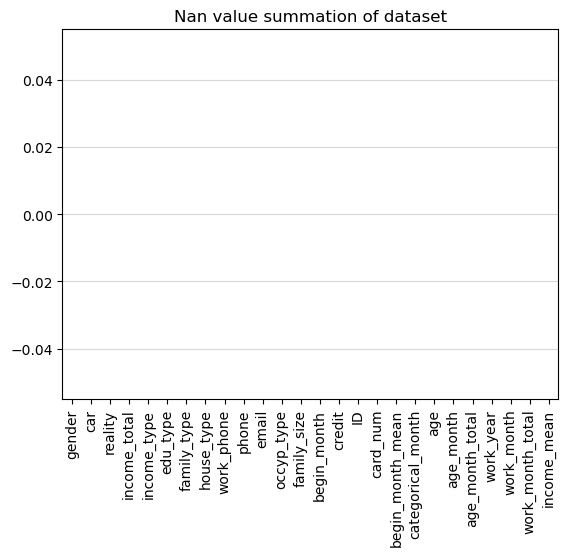

In [289]:
nan_value_count(user_list)

In [290]:
# corr 시각화
def corr_heatmap(dataset):
    """[상관관계 그래프]

    Args:
        dataset ([DataFrame]): [데이터프래임을 입력해주세요]
    """
    mask_ut=np.triu(np.ones(dataset.corr().shape)).astype(np.bool) 
    sns.heatmap(dataset.corr(), annot = True, cmap = 'RdYlBu_r', cbar_kws={"shrink": .5}, 
                annot_kws={"size": 6}, linewidths=.5, mask=mask_ut)
    plt.figure(figsize=(40,40))
    plt.show()

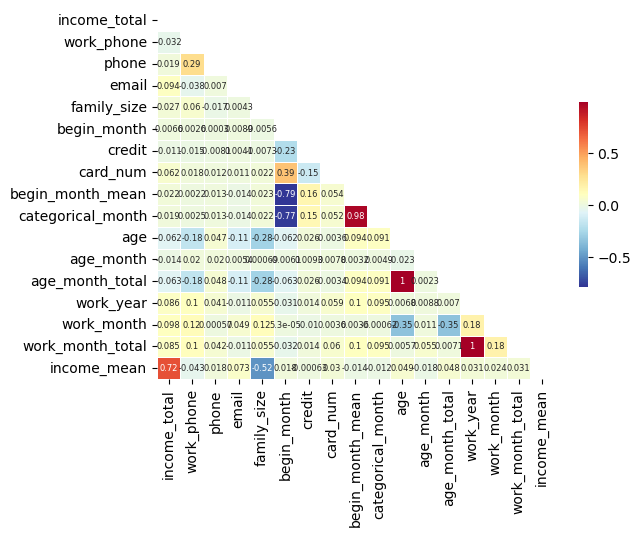

<Figure size 4000x4000 with 0 Axes>

In [291]:
corr_heatmap(user_list)

In [19]:
def col_corr_list(dataset, col_name):
    """[데이터 프레임 내 컬럼의 상관 관계를 보여주는 plot입니다.]

    Args:
        dataset ([DataFrame]): [데이터프레임을 입력해주세요]
        col_name ([column]): [데이터 내의 컬럼 이름을 입력해주세요]
    """
    # credit correlation을 크기별로 정렬하고 인덱스를 뽑습니다.
    y_label = dataset.corr()[[col_name]].sort_values(by=col_name,ascending=False).index.tolist()
    
    fig, ax = plt.subplots(figsize=(3, 6))
    sns.heatmap(dataset.corr()[[col_name]].sort_values(by=col_name,ascending=False), 
                vmin = -1, vmax = 1, annot=True, cmap="RdYlBu_r")
    ax.set_title('Correlation Heatmap with {}'.format(col_name), pad = 12)
    ax.set_yticklabels(y_label, rotation=0)
    plt.show()

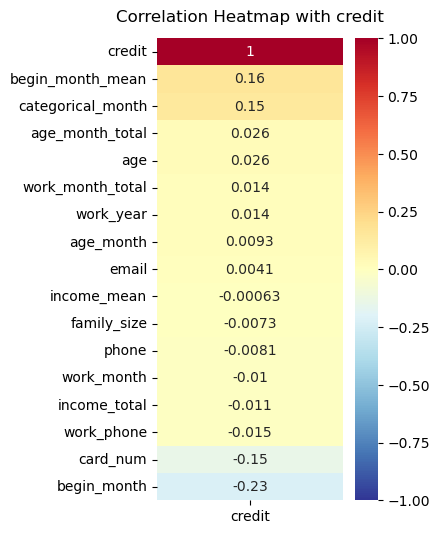

In [292]:
col_corr_list(user_list, 'credit')

In [233]:
def col_type(dataset):
    """[columne의 type별 분류를 실행해줍니다.]
    
        dataset ([DataFrame]): [데이터 프레임 명을 입력해 주세요]
        
        column의 datatype이 object인 것과 numeric인 것을 출력해줍니다.
    """
    object_list = []
    numeric_list = []
    for i in range(dataset.columns.nunique()):
        if (np.dtype(dataset[dataset.columns[i]]) == object) == True :
            object_list.append(dataset.columns[i])
        else:
            numeric_list.append(dataset.columns[i])
    
    print("object type인 column의 리스트 \n", object_list, '\n')
    print('numeric type인 column의 리스트 \n', numeric_list)
    

In [234]:
col_type(user_list)

object type인 column의 리스트 
 ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID'] 

numeric type인 column의 리스트 
 ['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'work_phone', 'phone', 'email', 'family_size', 'begin_month', 'credit', 'card_num', 'begin_month_mean', 'categorical_month', 'age', 'age_month', 'age_month_total', 'work_year', 'income_mean']


In [227]:
def boxplot_user_list(dataset, x_col, y_col, hue_name):
    """[data는 user_list를 대상으로 시행합니다. 가로방향으로 출력되므로 x,y축 컬럼 설정에 주의해주세요]

    Args:
        dataset ([DataFrame]): [데이터프레임을 입력해주세요]
        x_col ([column_numeric type]): [x축에 올 칼럼으로 numeric 타입을 입력하세요]
        y_col ([column_object type]): [y축에 올 칼럼으로 object 타입을 입력해주세요]
        hue_name ([column_object type]): [hue 옵션으로 카테고리별 분류를 시켜줍니다.]
    """
    sns.boxplot(x =x_col, y=y_col, hue=hue_name, data=dataset)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title=hue_name)
    plt.title('boxplot : each {} of {} (+ {} split)'.format(x_col,y_col,hue_name))
    plt.grid(axis='y', alpha = .5)
    plt.show()

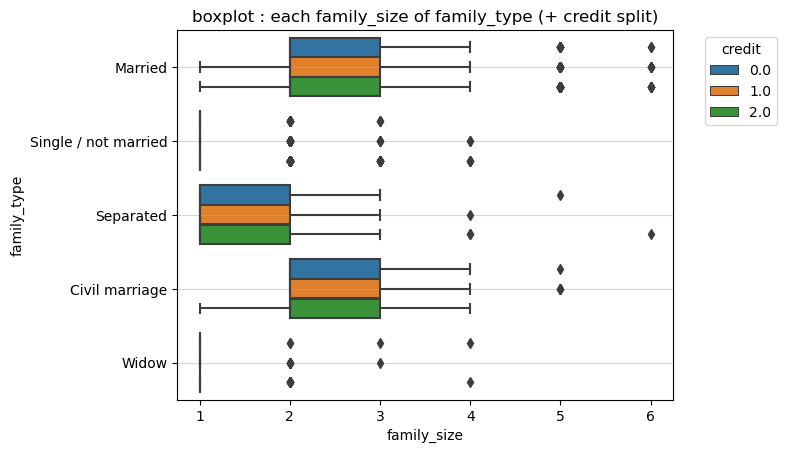

In [229]:
boxplot_user_list(user_list,'family_size', 'family_type','credit')

In [34]:
def count_plot(dataset, feature_1, hue_name):
    """[summary]

    Args:
        dataset ([DataFrame]): [데이터프레임 이름을 입력해주세요]
        feature_1 ([object type column]): [object_type인 칼럼을 입력해주세요]
        hue_name ([object type column]): [카테고리별 분류하기 위한 칼럼입니다]
    """
    sns.countplot(y=feature_1, data=dataset, hue=hue_name)
    plt.title('count of {} (category : {})'.format(feature_1, hue_name))
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='{}'.format(hue_name))
    plt.grid(axis='x', alpha = .5)
    plt.show()

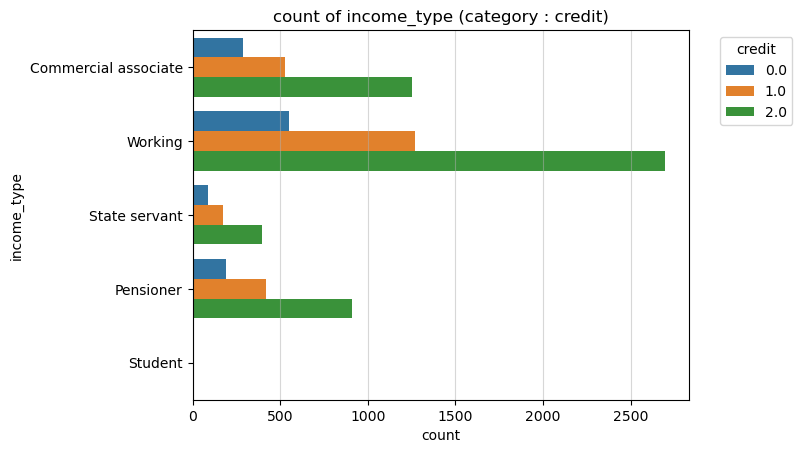

In [35]:
count_plot(user_list, 'income_type', 'credit')

In [86]:
def bar_plot(dataset, x_col, y_col, hue_name):
    """[summary]

    Args:
        dataset ([DataFrame]): [데이터프레임 이름을 입력해주세요]
        x_col ([numeric_type column]): [x축에 올 컬럼으로 평균치를 보여줍니다.]
        y_col ([object_type column]): [y축에 올 컬럼으로 카테고리별 평균으로 보여줍니다.]
        hue_name ([object_type column]): [카테고리별로 분류해줍니다]
    """
    sns.barplot(x=x_col, y=y_col, data= dataset, hue = hue_name, ci=None)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='{}'.format(hue_name))
    plt.title('each {} of {} mean (category : {})'.format(y_col, x_col, hue_name))
    # plt.gcf().text(0.3, -.05, 'black line : confidence level 95%', fontsize=10)
    plt.grid(axis='x', alpha = .5)
    plt.show()

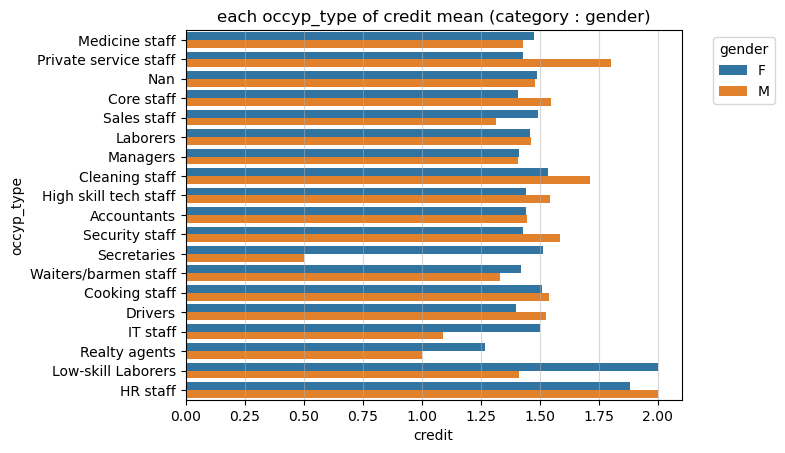

In [88]:
bar_plot(user_list, 'credit', 'occyp_type', 'gender')

In [90]:
def num_plot_occpy_nan(feature_1, feature_2):
    """ [dataset]
    
        표시되는 그룹은 occpy_type == Nan으로 표시된 사람들을 대상으로 그룹화한 것입니다.
        
        [parameter]
        feature_1 ([object type]): [y축에 표시할 objec입니다. 직업을 제외한 칼럼을 입력하세요]
        feature_2 ([numeric type]): [x축에 표시될 object별 feature_2의 mean값입니다.]
        red_line : feature_2의 전체 평균입니다.
    """
    grouped_occpy = user_list[user_list['occyp_type']=='Nan'].groupby(user_list[feature_1])
    grouped_occpy[feature_2].mean().plot(kind='barh')
    plt.axvline(user_list[user_list['occyp_type']=='Nan'][feature_2].mean(), 
                color= 'r', linestyle = ':',  label = '{} mean of all {}'.format(feature_2, feature_1))
    plt.xlabel('{} mean'.format(feature_2))
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title = feature_2)
    plt.grid(axis='x', alpha = .5)
    plt.title('each {} of {} mean'.format(feature_1, feature_2))
    plt.show()

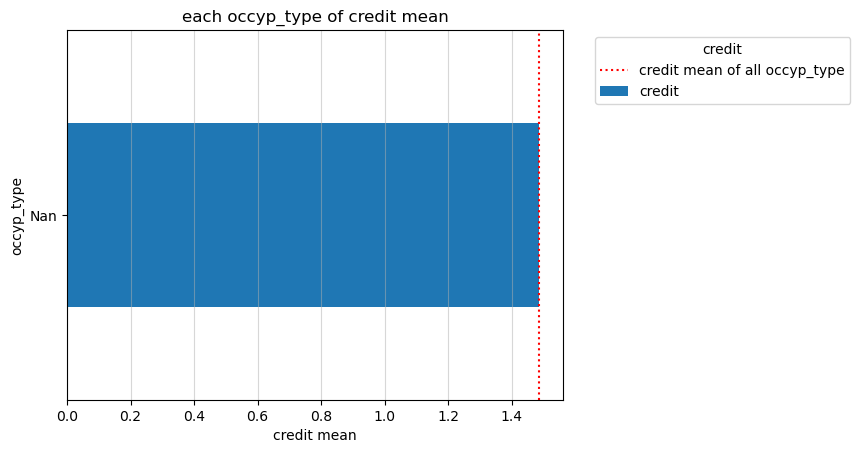

In [91]:
num_plot_occpy_nan('occyp_type', 'credit')

In [40]:
def plot_occpy_nan(feature_1st, feature_2nd):
    """[occpy_type이 Nan인 사람 대상입니다. feature_1st 각각의 object에 feature_2nd의 countplot으로 표시된 그래프를 나타냅니다.]

    Args:
        feature_1st ([object_type]): [dataset의 columns 중 object type 만 넣어주세요 (직업도 제외)]
        feature_2nd ([object_type]): [dataset의 columns 중 object type 만 넣어주세요 (직업도 제외)]
    """
    subset = user_list['occyp_type'].fillna('Nan')
    subset = user_list[user_list['occyp_type'] == 'Nan']
    sns.countplot(y=feature_1st, data = subset, hue = feature_2nd)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title = feature_2nd)
    plt.title('each {} of {} : count plot'.format(feature_1st, feature_2nd))
    plt.grid(axis='x', alpha = .5)
    plt.show()

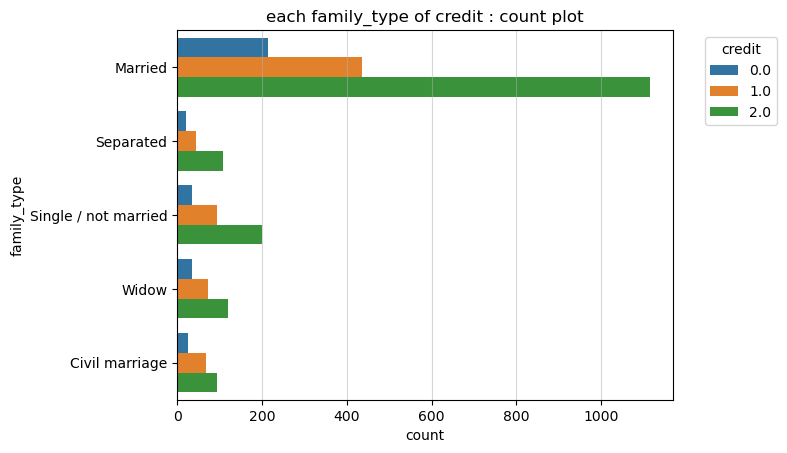

In [41]:
plot_occpy_nan('family_type', 'credit')